In [1]:
import sys
sys.path.append('../scripts')

from utils import *

# Genre Interaction Network

How are different game genres interconnected through shared developers or publishers, and what are the implications for genre diversification and cross-genre game development?

In [2]:
df = pd.read_csv(
    '../data/steam.csv', usecols=['name', 'genres', 'developer', 'publisher']
)

In [3]:
# Transform data to make genre, developer, and pubisher atomic.
row_list = []

for idx, row in (
    df
    .dropna()
    .applymap(lambda x: x.split(';'))
    .explode('name')
    .explode('genres')
    .explode('developer')
    .explode('publisher')
    .rename(columns={'name': 'game'})
).iterrows():
    if row.developer != row.publisher:
        row_list.extend([
            (idx, row.game, row.genres, row.developer),
            (idx, row.game, row.genres, row.publisher)
        ])
    elif row.developer == row.publisher:
        row_list.append((idx, row.game, row.genres, row.developer))

df_genre = (
    pd.DataFrame(
        row_list, columns=['index', 'game', 'genre',
                           'developer_publisher']
    )
    .set_index('index')
)

df_genre.head(10)

game   genre developer_publisher
index                                                            
0                      Counter-Strike  Action               Valve
1               Team Fortress Classic  Action               Valve
2                       Day of Defeat  Action               Valve
3                  Deathmatch Classic  Action               Valve
4           Half-Life: Opposing Force  Action    Gearbox Software
4           Half-Life: Opposing Force  Action               Valve
5                            Ricochet  Action               Valve
6                           Half-Life  Action               Valve
7      Counter-Strike: Condition Zero  Action               Valve
8               Half-Life: Blue Shift  Action    Gearbox Software

In [4]:
genres = set(df_genre['genre'])

# Get the number of shared developers and publishers between pairs of genres.
shared_dev_pub = {}
for genre1, genre2 in itertools.combinations(genres, 2):
    dev_pub_genre1 = set(
        df_genre[df_genre['genre'] == genre1]['developer_publisher']
    )
    dev_pub_genre2 = set(
        df_genre[df_genre['genre'] == genre2]['developer_publisher']
    )
    shared = len(dev_pub_genre1.intersection(dev_pub_genre2))
    if shared > 0:
        shared_dev_pub[(genre1, genre2)] = shared

list(shared_dev_pub)[:5]

[('Massively Multiplayer', 'Web Publishing'),
 ('Massively Multiplayer', 'Gore'),
 ('Massively Multiplayer', 'Sexual Content'),
 ('Massively Multiplayer', 'Audio Production'),
 ('Massively Multiplayer', 'Free to Play')]

In [5]:
df_genre_weight = (
    pd.DataFrame(
        [(genre1, genre2, weight)
         for (genre1, genre2), weight in shared_dev_pub.items()],
        columns=['genre1', 'genre2', 'weight']
    )
)

df_genre_weight.sort_values('weight', ascending=False).head(10)

genre1        genre2  weight
150      Indie        Action    8829
141      Indie     Adventure    7270
130      Indie        Casual    6826
298  Adventure        Action    5033
170     Casual        Action    3912
134      Indie      Strategy    3652
161     Casual     Adventure    3636
132      Indie    Simulation    3525
135      Indie           RPG    3187
133      Indie  Early Access    2853

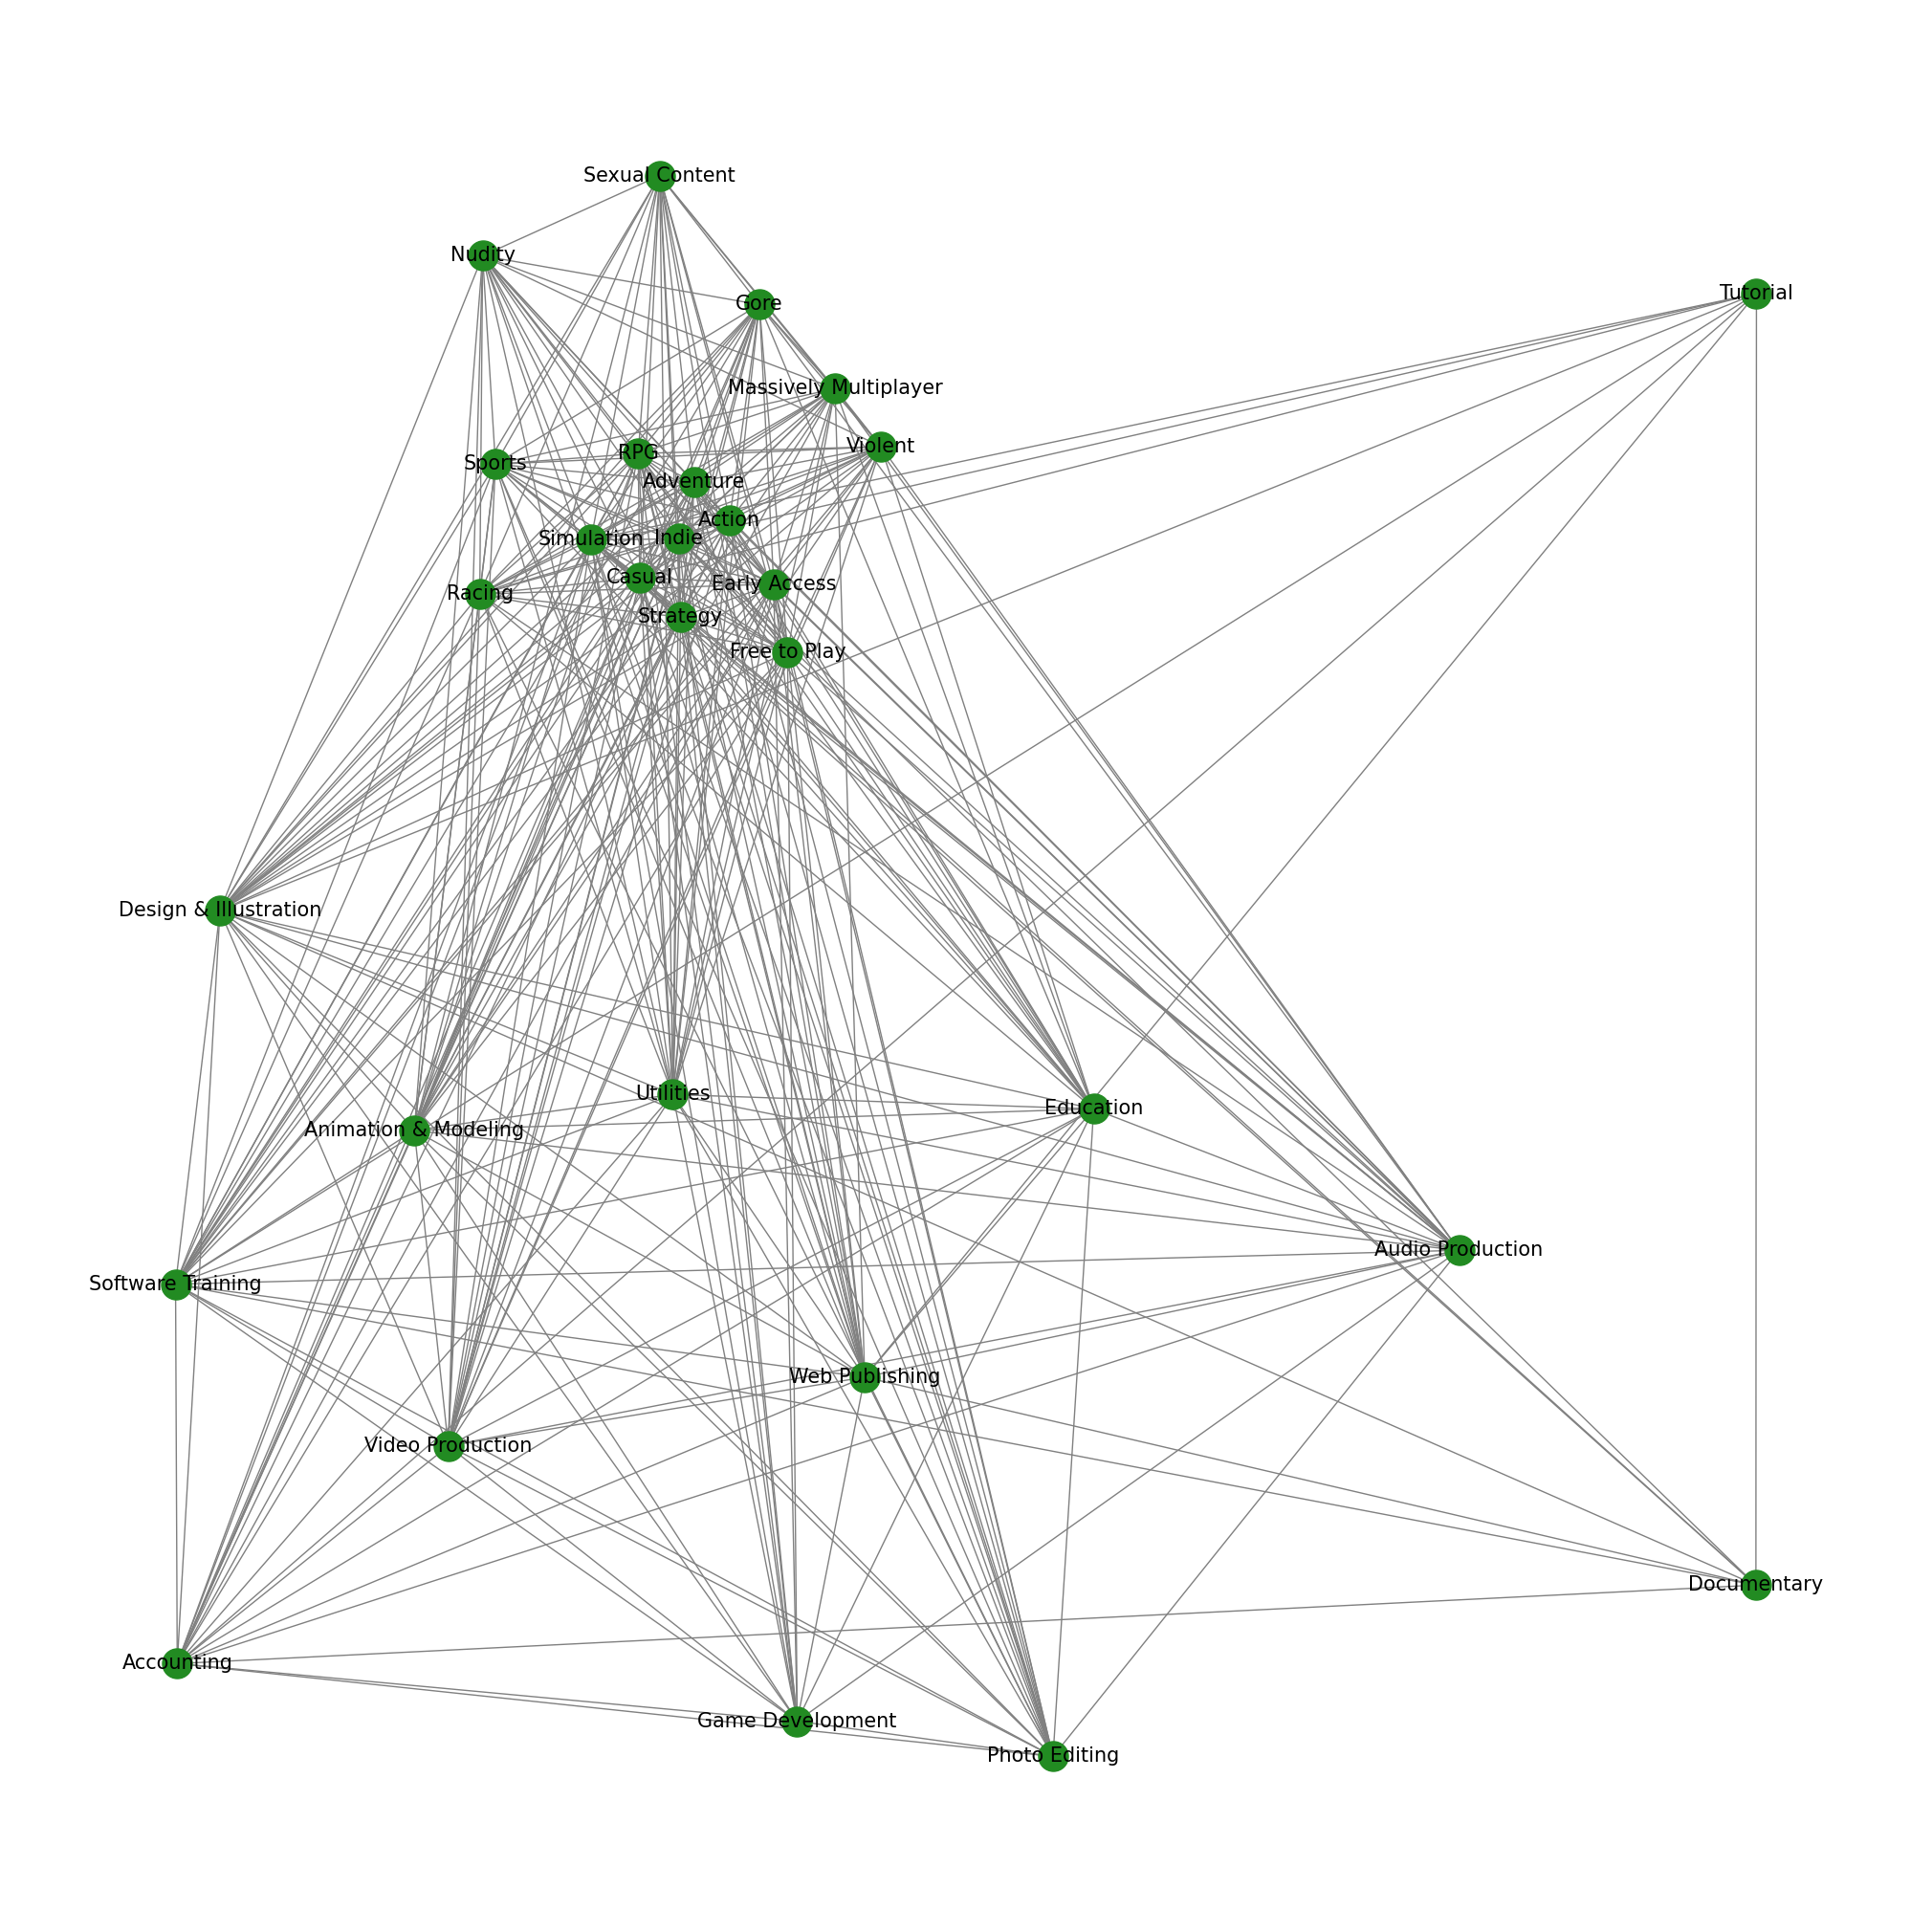

In [6]:
G = nx.from_pandas_edgelist(
    df_genre_weight, 'genre1', 'genre2', edge_attr='weight',
    create_using=nx.Graph()
)

pos = nx.fruchterman_reingold_layout(G, k=4, seed=0)

plt.figure(figsize=(20, 20))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='forestgreen',
        edge_color='gray', font_size=15,
        font_color='black')
edge_labels = nx.get_edge_attributes(G, 'weight')
# plt.title("Genre Interactions between Games")
plt.axis('off')
plt.savefig('../figures/genre-interactions-all.png', dpi=300)

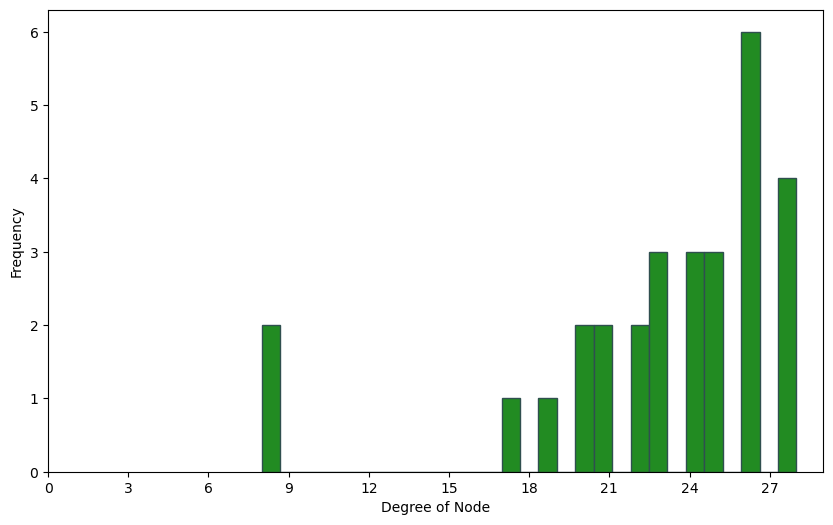

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(dict(G.degree).values(),
         bins=len(dict(G.degree).values()),
         color='forestgreen',
         ec='darkslategray')
# plt.title('Degree Distribution of Genre Interaction Network')
plt.xlabel('Degree of Node')
plt.ylabel('Frequency')
plt.xticks(range(0, len(dict(G.degree).values()), 3))
plt.savefig('../figures/genre-interaction-all-degree-dist.png', dpi=300)

In [8]:
top_dev_pub = pd.read_csv('../data/developer_publisher.csv')

In [9]:
df_game_genre = (
    df_genre[df_genre.developer_publisher.isin(top_dev_pub.squeeze().tolist())]
    [['game', 'genre']]
    .applymap(unidecode)
)

df_game_genre.head()

game   genre
index                                   
4      Half-Life: Opposing Force  Action
8          Half-Life: Blue Shift  Action
67             Call of Duty(r) 2  Action
67             Call of Duty(r) 2  Action
67             Call of Duty(r) 2  Action

In [10]:
display(
    df[(df.genres.str.contains('Ut')) &
       ((df.developer.isin((top_dev_pub.squeeze().tolist()))) |
        (df.publisher.isin((top_dev_pub.squeeze().tolist()))))]
)

# Remove isolated genre node in top developers and publishers list
df_game_genre = df_game_genre[df_game_genre.genre != 'Utilities']

name            developer           publisher     genres
9106  Disney Movies VR  Walt Disney Studios  Disney Interactive  Utilities

In [11]:
G = nx.Graph()
G.add_nodes_from(set(df_game_genre['game']), label='Game')
G.add_nodes_from(set(df_game_genre['genre']), label='Genre')
G.add_edges_from([(game, genre) for game, genre in df_game_genre.to_numpy()])

get_graph_stats(G)

Total number of nodes: 795
Total number of edges: 1364

Minimum degree: 1
Maximum degree: 394
Average degree: 1.72

Network density: 0.43%


## Genres

In [12]:
# Get Genres subgraph
genres = {node for node, attr in G.nodes(data=True)
          if attr['label'] == 'Genre'}
G_genres = nx.bipartite.projected_graph(G, genres)

get_graph_stats(G_genres)

Total number of nodes: 16
Total number of edges: 71

Minimum degree: 2
Maximum degree: 15
Average degree: 4.44

Network density: 59.17%


In [13]:
callables = [
    nx.degree_centrality,
    nx.betweenness_centrality,
    nx.closeness_centrality,
    nx.eigenvector_centrality
]

# Get developers and publishers that are Top 10 in all centrality measures.
central_dev_pub = set()
concat_list = {}
for centrality_fn in callables:
    series = get_central_nodes_as_series(G_genres, centrality_fn)
    concat_list.update({centrality_fn.__name__: series})
    if central_dev_pub == set():
        central_dev_pub = central_dev_pub.union(set(series.index))
    else:
        central_dev_pub = central_dev_pub.intersection(set(series.index))

df_central_nodes = (
    pd.concat(concat_list, axis=1).loc[list(central_dev_pub)].sort_values(
        ['degree_centrality', 'eigenvector_centrality', 'closeness_centrality',
         'betweenness_centrality'],
        ascending=False
    )
)
with pd.option_context('display.precision', 4):
    display(df_central_nodes)

degree_centrality  betweenness_centrality  closeness_centrality  \
Action                 1.0000                  0.1856                1.0000   
Adventure              0.9333                  0.0808                0.9375   
Strategy               0.8000                  0.0372                0.8333   
Simulation             0.7333                  0.0264                0.7895   
Violent                0.7333                  0.0339                0.7895   
Casual                 0.6667                  0.0185                0.7500   
RPG                    0.6667                  0.0229                0.7500   
Sports                 0.6000                  0.0113                0.7143   
Indie                  0.6000                  0.0160                0.7143   

            eigenvector_centrality  
Action                      0.3497  
Adventure                   0.3450  
Strategy                    0.3150  
Simulation                  0.2944  
Violent                     0.2887  
Casual                      0.2786  
RPG                         0.2712  
Sports                      0.2511  
Indie                       0.2470

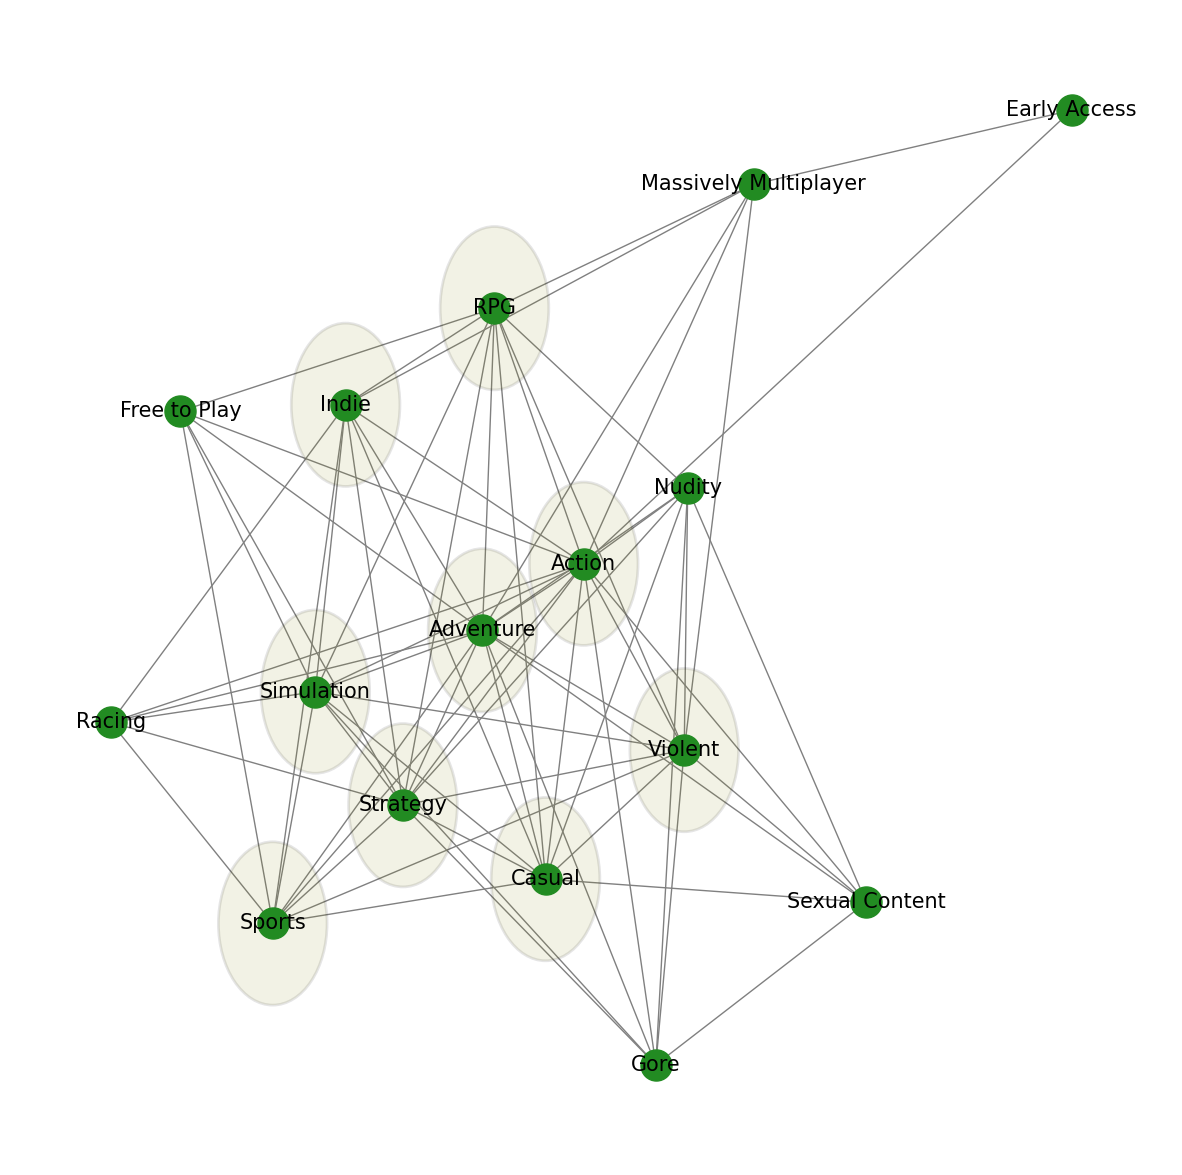

In [14]:
plt.figure(figsize=(15, 15))
pos_genres = nx.fruchterman_reingold_layout(G_genres, seed=0)

nx.draw_networkx_edges(G_genres, pos_genres, edge_color='gray')
nx.draw_networkx_nodes(G_genres, pos_genres, node_size=500,
                       node_color='forestgreen', label='Games')
nx.draw_networkx_labels(G_genres, pos_genres, font_size=15)

for node in df_central_nodes.index:
    circle = patches.Circle(
        pos_genres[node], 0.1, edgecolor='black', alpha=0.1,
        facecolor='olive', lw=2
    )
    plt.gca().add_patch(circle)
# plt.title('Genres Projection')
plt.axis('off')
plt.savefig('../figures/genre-interactions-top-dev-pub.png', dpi=300)

## Games

In [15]:
# Get Games subgraph
games = {node for node, attr in G.nodes(data=True) if attr['label'] == 'Game'}
G_games = nx.bipartite.projected_graph(G, games)

get_graph_stats(G_games)

Total number of nodes: 779
Total number of edges: 135833

Minimum degree: 6
Maximum degree: 695
Average degree: 174.37

Network density: 44.82%


In [16]:
# Convert the NetworkX graph to an igraph graph
ig_graph = ig.Graph.TupleList(G_games.edges(), directed=False)

top_n = 20

# Calculate centrality measures using igraph
ig_deg_centrality = np.array(ig_graph.degree())
ig_bet_centrality = np.array(ig_graph.betweenness())
ig_close_centrality = np.array(ig_graph.closeness())
ig_eig_centrality = np.array(ig_graph.eigenvector_centrality())

# Identify the top 10 central nodes for each centrality measure
top_deg = np.argsort(ig_deg_centrality)[-top_n:][::-1]
top_bet = np.argsort(ig_bet_centrality)[-top_n:][::-1]
top_close = np.argsort(ig_close_centrality)[-top_n:][::-1]
top_eig = np.argsort(ig_eig_centrality)[-top_n:][::-1]

central_node_idx = set(top_deg).union(set(top_bet),
                                                set(top_close),
                                                set(top_eig))
central_games = []
for idx in central_node_idx:
    central_games.append(ig_graph.vs[idx]['name'])
central_games

['Hunting Unlimited(tm) 2008',
 'Shenmue I & II',
 'The Deadly Tower of Monsters',
 'Disney*Pixar Cars 2: The Video Game',
 'Hyperspeed',
 'theHunter: Call of the Wild(tm)',
 'theHunter Classic',
 "Drawn(r): Dark Flight(tm) Collector's Edition",
 'TEMBO THE BADASS ELEPHANT',
 'Boundless',
 'Space Rogue Classic',
 'Rollers of the Realm',
 'Yakuza 0',
 'Thrillville(r): Off the Rails(tm)',
 "Disney*Pixar Cars Toon: Mater's Tall Tales",
 'Sonic Mania',
 'Murdered: Soul Suspect',
 "Campgrounds: The Endorus Expedition Collector's Edition",
 'Scribblenauts Unmasked: A DC Comics Adventure',
 'Marine Park Empire',
 'Abyss Odyssey',
 'Scribblenauts Unlimited',
 "Disney's Treasure Planet: Battle of Procyon",
 'System Shock: Enhanced Edition',
 'Zoo Empire',
 'Yakuza Kiwami',
 'Dungeon of the Endless(tm)',
 'Forgotton Anne',
 'Deus Ex: The Fall',
 'Restaurant Empire II',
 'Lifeline',
 'Scooby Doo! & Looney Tunes Cartoon Universe: Adventure',
 'Black The Fall',
 'Spirits of Xanadu',
 '7th Legion']

In [17]:
partition = community.best_partition(G_games, random_state=1337)
color_dict = {0: 'gold', 1: 'indigo', 2: 'darkgreen'}

central_games_dict = {game: partition[game] for game in central_games}

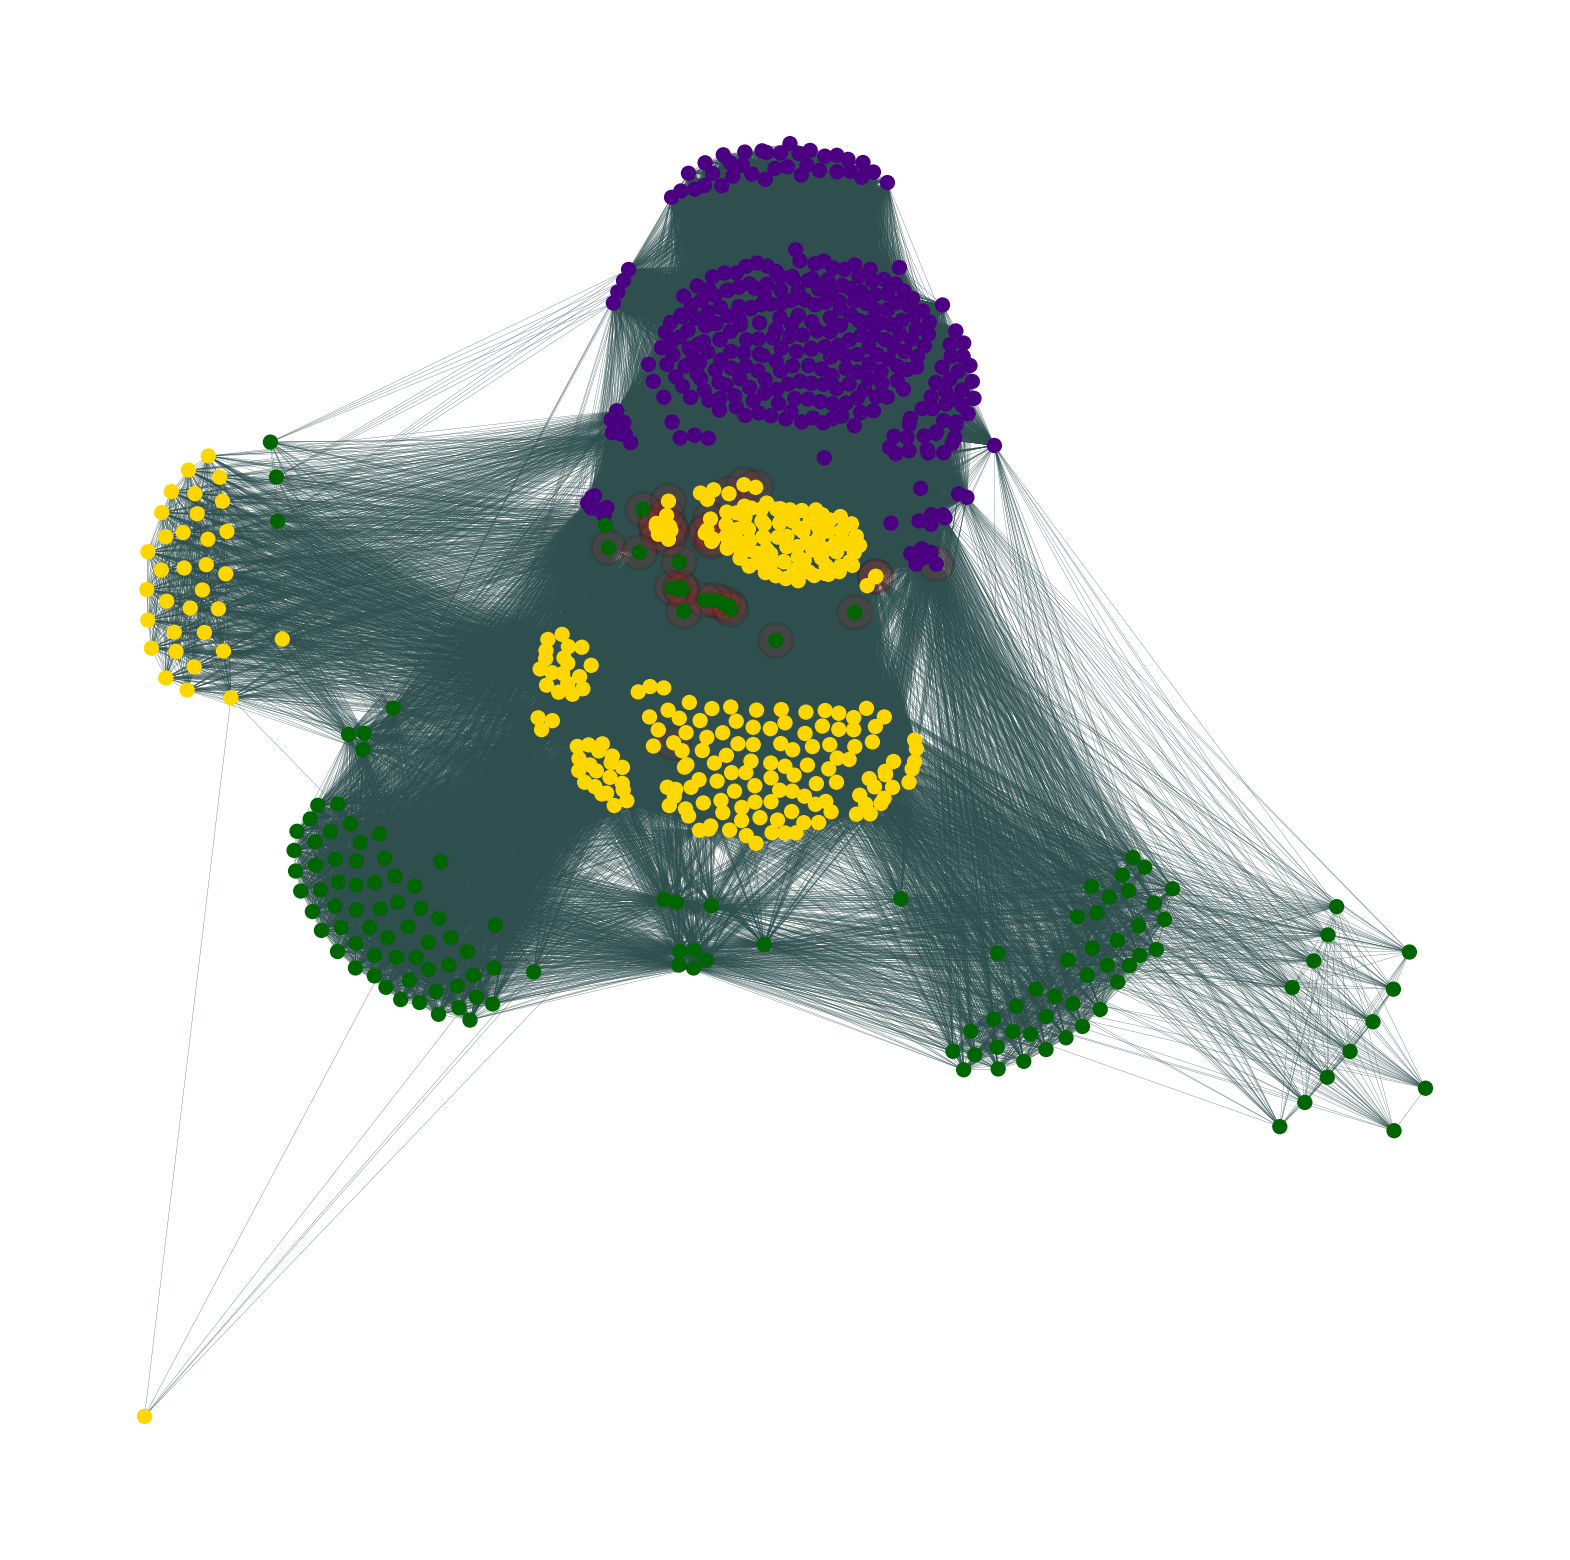

In [18]:
plt.figure(figsize=(20, 20))
pos_games = nx.spring_layout(G_games, seed=0, k=0.2)

node_colors = [color_dict[partition[node]] for node in G_games.nodes()]

nx.draw_networkx_nodes(
    G_games, pos_games, node_size=100, node_color=node_colors, label='Games'
)
nx.draw_networkx_edges(
    G_games, pos_games, width=0.20, edge_color='darkslategray'
)
for node in central_games:
    circle = patches.Circle(
        pos_games[node], 0.02, edgecolor='black', alpha=0.1,
        facecolor='r', lw=2
    )
    plt.gca().add_patch(circle)

# nx.draw_networkx_labels(G_games, pos_games, font_size=8)
# plt.title('Games Projection')
plt.axis('off')
plt.savefig('../figures/clustered-game-network.png', dpi=300)

In [19]:
cluster0 = [game for game in partition.keys() if partition[game] == 0]
cluster1 = [game for game in partition.keys() if partition[game] == 1]
cluster2 = [game for game in partition.keys() if partition[game] == 2]

In [20]:
df_genre[df_genre.game.isin(cluster0)]['genre'].value_counts().head()

genre
Action       647
Adventure    259
RPG          134
Strategy     104
Violent       40
Name: count, dtype: int64

In [21]:
df_genre[df_genre.game.isin(cluster1)]['genre'].value_counts().head()

genre
Adventure     561
Casual        502
Simulation     29
RPG            21
Indie          13
Name: count, dtype: int64

In [22]:
df_genre[df_genre.game.isin(cluster2)]['genre'].value_counts().head()

genre
Simulation    187
Strategy      185
Sports        116
Racing         89
Indie          46
Name: count, dtype: int64

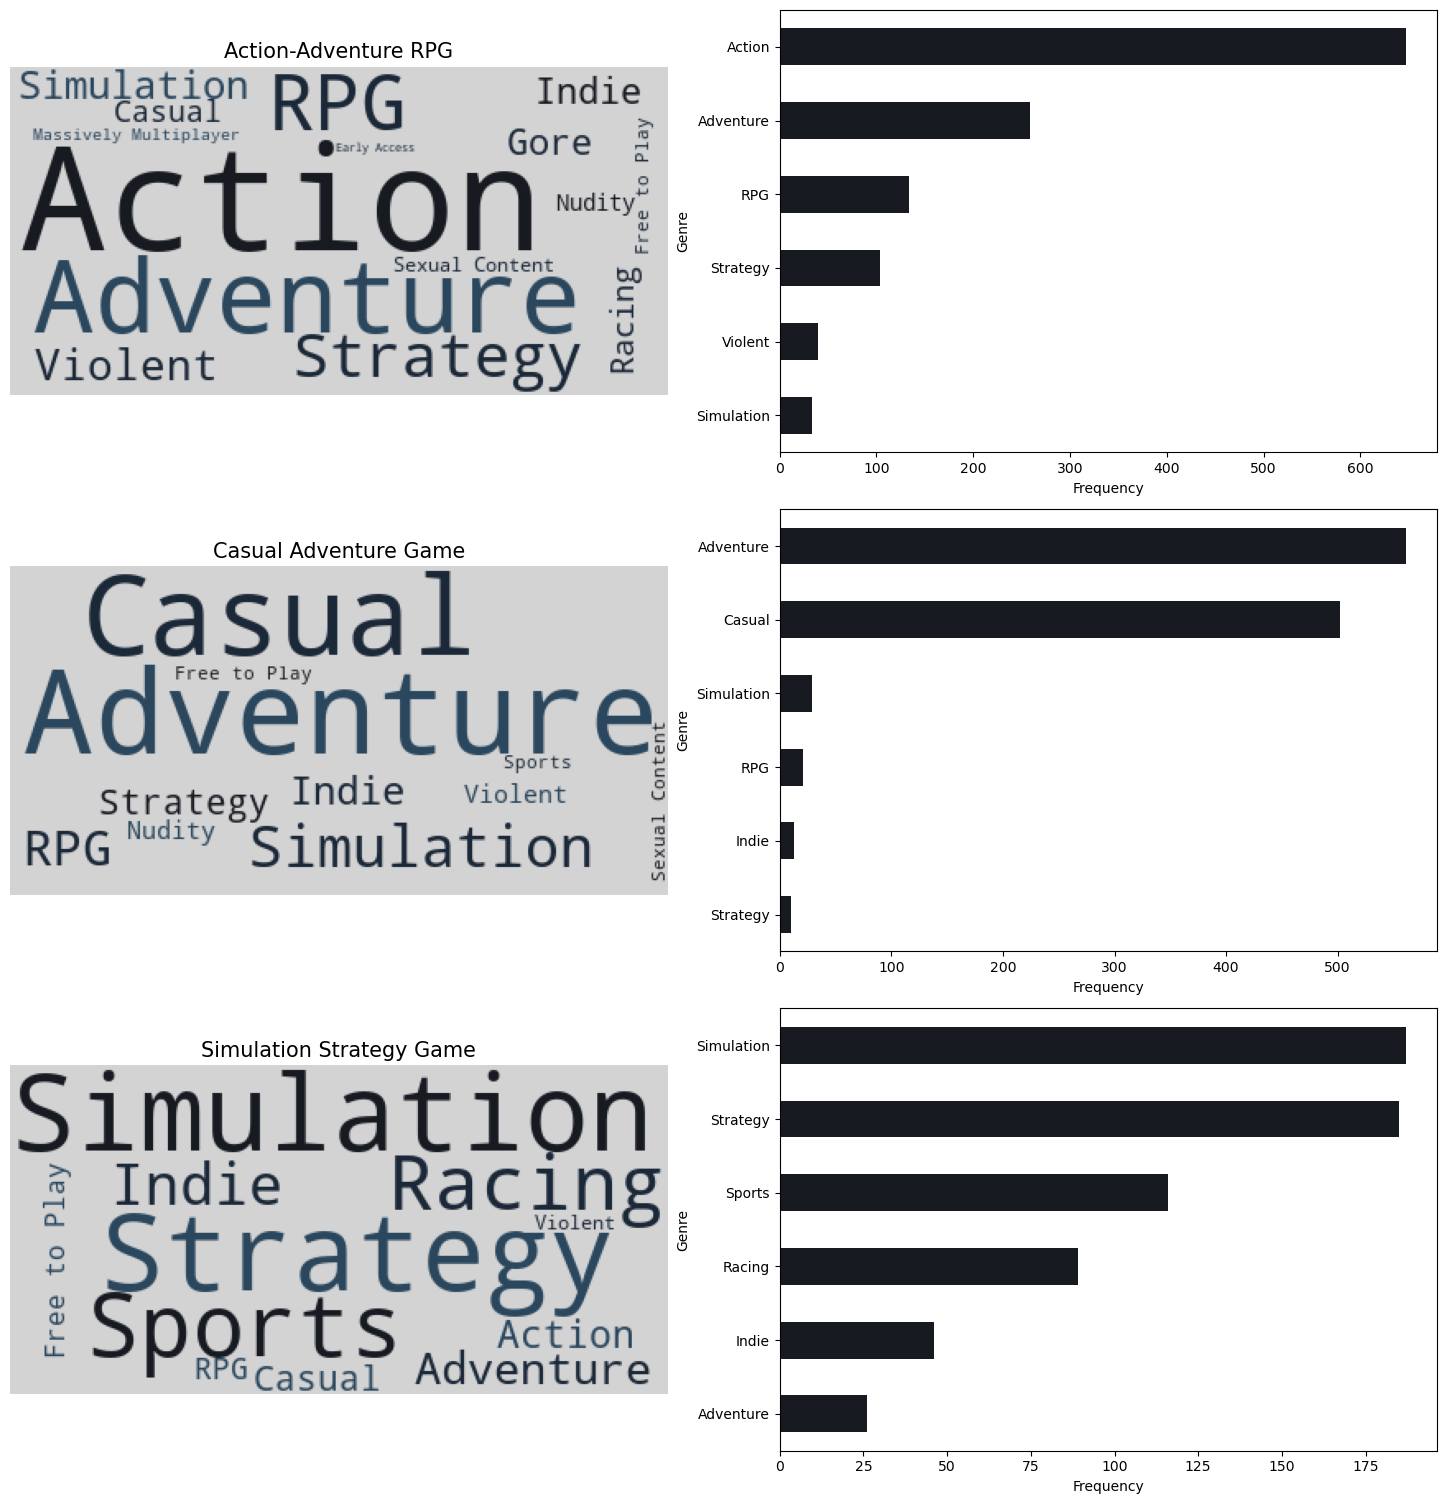

In [23]:
cmap = ListedColormap(['#171a21', '#1b2838', '#2a475e'])

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout(w_pad=5, h_pad=2)
ax = axes.flat
for i, (cluster, name) in enumerate(zip([cluster0, cluster1, cluster2],
                                        ['Action-Adventure RPG',
                                         'Casual Adventure Game',
                                         'Simulation Strategy Game'])):
    wc = WordCloud(
        width=400,
        height=200,
        colormap=cmap,
        background_color='lightgray'
    )
    wc.generate_from_frequencies(
        df_genre[df_genre.game.isin(cluster)]['genre'].value_counts()
    )
    ax[2*i].imshow(wc)
    ax[2*i].set_title(name, fontsize=15)
    ax[2*i].axis('off')

    df_genre[
        df_genre.game.isin(cluster)
    ]['genre'].value_counts().iloc[:6].sort_values().plot.barh(
        ax=ax[2*i+1], cmap=cmap
    )
    ax[2*i+1].set_xlabel('Frequency')
    ax[2*i+1].set_ylabel('Genre')
fig.savefig('../figures/game-clusters-wc-barh.png', dpi=300)

In [30]:
top_cluster_genres = ['Action', 'Adventure', 'RPG']

df_genre[(df_genre.game.isin(cluster0)) &
         (df_genre.genre.isin(top_cluster_genres))].game.value_counts().head()

game
Borderlands: The Pre-Sequel          44
Tomb Raider                          44
Life is Strange - Episode 1          34
Life is Strange: Before the Storm    32
Deus Ex: Mankind Divided             32
Name: count, dtype: int64

In [32]:
top_cluster_genres = ['Adventure', 'Casual']

df_genre[(df_genre.game.isin(cluster1)) &
         (df_genre.genre.isin(top_cluster_genres))].game.value_counts().head()

game
Castle of Illusion                                                           14
Starship Titanic                                                              8
Titanic: Adventure Out Of Time                                                8
Dark Parables: The Little Mermaid and the Purple Tide Collector's Edition     8
The LEGO Movie 2 Videogame                                                    7
Name: count, dtype: int64

In [35]:
top_cluster_genres = ['Simulation', 'Strategy', 'Sports']

df_genre[(df_genre.game.isin(cluster2)) &
         (df_genre.genre.isin(top_cluster_genres))].game.value_counts().head()

game
DiRT Rally             32
DiRT 4                 30
GRID Autosport         16
XCOM: Enemy Unknown    16
Company of Heroes 2    16
Name: count, dtype: int64